# Utilizing cPeaks in SnapATAC2 pipeline to analyze 5K PBMC dataset from 10X genomics

This jupyter notebook is adapted from [SnapATAC2 standard pipeline](https://kzhang.org/SnapATAC2/tutorials/pbmc.html)

## Import library and environment setup

In [1]:
import snapatac2 as snap

In [2]:
snap.__version__

'2.5.3'

In [3]:
# Input files
fragment_file = snap.datasets.pbmc5k()
fragment_file

PosixPath('/Users/chenwenchang/Library/Caches/snapatac2/atac_pbmc_5k.tsv.gz')

A fragment file refers to a file containing information about the fragments of DNA that are accessible and have been sequenced. Here are more information about the [Fragment File](https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/output/fragments).

If you do not have a fragment file for your experiment, you can make one from a BAM file, see [pp.make_fragment_file()](https://kzhang.org/SnapATAC2/api/_autosummary/snapatac2.pp.make_fragment_file.html#snapatac2.pp.make_fragment_file).

## Preprocessing

We begin data preprocessing by importing fragment files and calculating basic quality control (QC) metrics using the [pp.import_data()](https://kzhang.org/SnapATAC2/version/2.5/api/_autosummary/snapatac2.pp.import_data.html#snapatac2.pp.import_data) function.

This function compresses and stores the fragments in an AnnData object for later usage(To learn more about SnapATAC2's anndata implementation, click [here](https://kzhang.org/epigenomics-analysis/anndata.html)). During this process, various quality control measures, such as TSS enrichment and the number of unique fragments per cell, are computed and stored in the anndata as well.

When the `file` argument is not specified, the AnnData object is created and stored in the computer's memory. However, if the `file` argument is provided, the AnnData object will be backed by an hdf5 file. In "backed" mode, [pp.import_data()](../api/_autosummary/snapatac2.pp.import_data.html#snapatac2.pp.import_data) processes the data in chunks and streams the results to the disk, using only a small, fixed amount of memory. Therefore, it is recommended to specify the `file` parameter when working with large datasets and limited memory resources. Keep in mind that analyzing data in "backed" mode is slightly slower than in "memory" mode.

In this tutorial we will use the backed mode. To learn more about the differences between these two modes, click [here](https://kzhang.org/epigenomics-analysis/anndata.html).

In [4]:
%%time
data = snap.pp.import_data(
    fragment_file,
    chrom_sizes=snap.genome.hg38,
    file="pbmc.h5ad",  # Optional
    sorted_by_barcode=False,
)
data

CPU times: user 7min 35s, sys: 37.5 s, total: 8min 12s
Wall time: 4min 30s


AnnData object with n_obs x n_vars = 14232 x 0 backed at 'pbmc.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

[pp.import_data()](../api/_autosummary/snapatac2.pp.import_data.html#snapatac2.pp.import_data) computes only basic QC metrics like the number of unique fragments per cell, fraction of duplicated reads and fraction of mitochondrial read. More advanced metrics can be computed by other functions.

Researchers often use TSS enrichment as a quality control metric in these assays. If there is a clear and pronounced enrichment of reads or signal around TSS regions, it suggests that the experiment has captured relevant genomic features and is likely to yield biologically meaningful results. Conversely, a lack of TSS enrichment may indicate issues with the experiment's quality or data processing.

TSSe scores of individual cells can be computed using the [metrics.tsse()](../api/_autosummary/snapatac2.metrics.tsse.html#snapatac2.metrics.tsse) function.

In [5]:
%%time
snap.metrics.tsse(data, snap.genome.hg38)

CPU times: user 2min 23s, sys: 12.4 s, total: 2min 35s
Wall time: 43.5 s


To identify usable/high-quality cells, we can plot TSSe scores against number of unique fragments for each cell.

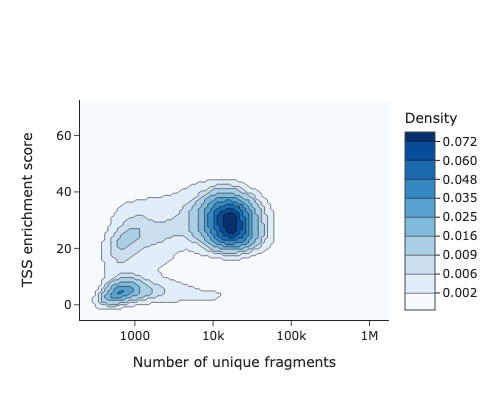

In [6]:
snap.pl.tsse(data, interactive=False)

The cells in the upper right represent valid or high-quality cells, whereas those in the lower left represent low-quality cells or empty droplets. Based on this plot, we decided to set a minimum TSS enrichment of 10 and a minimum number of fragments of 5,000 to filter the cells.

In [7]:
%%time
snap.pp.filter_cells(data, min_counts=5000, min_tsse=10, max_counts=100000)
data

CPU times: user 22 s, sys: 3.03 s, total: 25 s
Wall time: 26.8 s


AnnData object with n_obs x n_vars = 4564 x 0 backed at 'pbmc.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

We next create a cell by peak matrix based on cPeaks reference files.

In [8]:
cpeaks_path = '../data/cpeaks_hg38.bed'
with open(cpeaks_path) as cpeaks_file:
    cpeaks = cpeaks_file.read().strip().split('\n')
cpeaks = [peak.split('\t')[0] + ':' + peak.split('\t')[1] + '-' + peak.split('\t')[2] for peak in cpeaks]

In [9]:
data = snap.pp.make_peak_matrix(data, use_rep=cpeaks)
data

/Users/chenwenchang/opt/anaconda3/envs/cpeaks310/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



AnnData object with n_obs × n_vars = 4564 × 1567527
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'

Next, we perform feature selection using [pp.select_features()](../api/_autosummary/snapatac2.pp.select_features.html#snapatac2.pp.select_features). The result is stored in `data.var['selected']` and will be automatically utilized by relevant functions such as [pp.scrublet()](../api/_autosummary/snapatac2.pp.scrublet.html#snapatac2.pp.scrublet) and [tl.spectral()](../api/_autosummary/snapatac2.tl.spectral.html#snapatac2.tl.spectral).

The default feature selection algorithm chooses the most accessible features. The `n_features` parameter determines the number of features or bins used in subsequent analysis steps. Generally, including more features improves resolution and reveals finer details, but it may also introduce noise. To optimize results, experiment with the `n_features` parameter to find the most appropriate value for your specific dataset.

Additionally, you can provide a filter list to the function, such as a blacklist or whitelist. For example, use `pp.select_features(data, blacklist='blacklist.bed')`.

In [10]:
snap.pp.select_features(data)

2024-03-09 21:46:45 - INFO - Selected 500000 features.


### Doublet removal

Here we apply a customized scrublet algorithm to identify potential doublets. Calling [pp.scrublet()](../api/_autosummary/snapatac2.pp.scrublet.html#snapatac2.pp.scrublet) will assign probabilites of being doublets to the cells. We can then use `pp.filter_doublets` to get the rid of the doublets.

In [11]:
%%time
snap.pp.scrublet(data)

2024-03-09 21:46:46 - INFO - Simulating doublets...
2024-03-09 21:46:49 - INFO - Spectral embedding ...
2024-03-09 21:49:34 - INFO - Calculating doublet scores...


CPU times: user 3min 22s, sys: 17.5 s, total: 3min 40s
Wall time: 2min 51s


This line does the actual filtering.

In [12]:
snap.pp.filter_doublets(data)
data

2024-03-09 21:49:36 - INFO - Detected doublet rate = 2.958%
/Users/chenwenchang/opt/anaconda3/envs/cpeaks310/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



AnnData object with n_obs × n_vars = 4429 × 1567527
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'scrublet_sim_doublet_score', 'doublet_rate'

## Dimenstion reduction <a name="dimension_reduction"></a>

To calculate the lower-dimensional representation of single-cell chromatin profiles, we employ spectral embedding for dimensionality reduction. The resulting data is stored in `data.obsm['X_spectral']`. Comprehensive information about the dimension reduction algorithm we utilize can be found in the [algorithm documentation](https://kzhang.org/epigenomics-analysis/dim_reduct.html).

In [13]:
%%time
snap.tl.spectral(data)

CPU times: user 1min 46s, sys: 16.1 s, total: 2min 2s
Wall time: 51.1 s


We then use UMAP to embed the cells to 2-dimension space for visualization purpose. This step will have to be run after `snap.tl.spectral` as it uses the lower dimesnional representation created by the spectral embedding.

In [14]:
%%time
snap.tl.umap(data)

/Users/chenwenchang/opt/anaconda3/envs/cpeaks310/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 34 s, sys: 1.42 s, total: 35.4 s
Wall time: 36.8 s


## Clustering analysis <a name="clustering"></a>

We next perform graph-based clustering to identify cell clusters. We first build a k-nearest neighbour graph using `snap.pp.knn`, and then use the Leiden community detection algorithm to identify densely-connected subgraphs/clusters in the graph.

In [15]:
%%time
snap.pp.knn(data)
snap.tl.leiden(data)

CPU times: user 434 ms, sys: 88.3 ms, total: 522 ms
Wall time: 448 ms


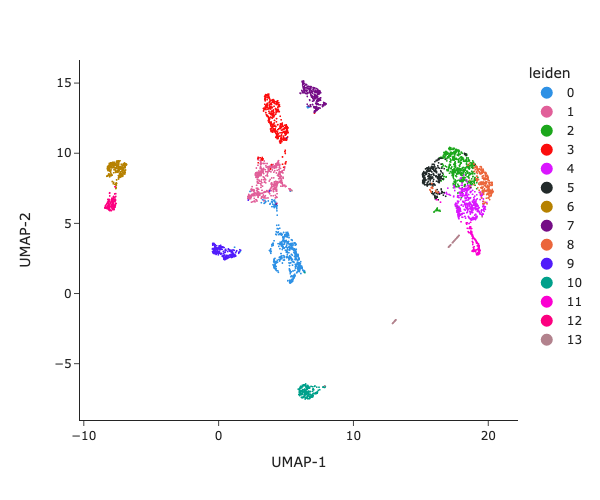

In [16]:
snap.pl.umap(data, color='leiden', interactive=False, height=500)

The plot can be saved to a file using the `out_file` parameter. The suffix of the filename will used to determined the output format.

In [17]:
snap.pl.umap(data, color='leiden', show=False, out_file="umap.pdf", height=500)
snap.pl.umap(data, color='leiden', show=False, out_file="umap.html", height=500)